# Beyond random forests: more ensemble models

Ensembles are the combination of different machine learning models, where by averaging the results of all models trained together on the same dataset, the result can be away good than any individual model. These types of models can be used for all kinds of tasks, including classification, regression and detecting anomalies. 

In his book *[Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*, *Aurelion Geron* gave a perfect analogy describing the ensemble learning: "Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the *wisdom of the crowd*. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method."

Random Forests that was used in the previous assignment is an example of ensemble models. It combined different decision trees. Usually, these types of models are classified into three groups that will be covered in this assignment:

* Averaging Methods: Such as voting classifiers/regressors, bagging classifiers/regressors, random forests, extra trees classifier/regressor, etc...
* Boosting Methods: Gradient Boosting, AdaBoost, XGBoost
* Stacking in which instead of averaging the results of multiple models, multiple models are trained on the full training set and there is a final model trained on the different subsets (folds) of the training set. 

Most of the above algorithms are implemented in Sklearn, except XGBoost and Stacking which is implemented indirectly.

Like said in the beginning, these types of models can be used for both regression and classification, but this assignment will consider classification domain and for giving focus on the ensemble models, we will use the same dataset we used previouly, in random forests. 

## Ensemble methods for classification

## Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

## Loading the data

In this assignment, we will use Random forests to build a classifier that identify the increase or decrease of the electricity using "the data that was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations."

"The dataset contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends). Source: [Open ML electricity](https://www.openml.org/d/151).

Here are the information about the features:

* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1 
* Day: day of the week (1-7) 
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1 
* NSWprice: New South Wales electricity price, normalized between 0 and 1 
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1 
* VICprice: Victoria electricity price, normalized between 0 and 1 
* VICdemand: Victoria electricity demand, normalized between 0 and 1 
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1 


Let's load the dataset using Sklearn `fetch_ml function`. 

In [2]:
# Let's hide warnings

import warnings

warnings.filterwarnings("ignore")

In [3]:
from sklearn.datasets import fetch_openml

elec_data = fetch_openml(name="electricity", version=1)

In [4]:
type(elec_data)

sklearn.utils._bunch.Bunch

In [5]:
elec_data.details

{'id': '151',
 'name': 'electricity',
 'version': '1',
 'description_version': '1',
 'format': 'ARFF',
 'creator': ['M. Harries', 'J. Gama', 'A. Bifet'],
 'collection_date': '1998-12-05',
 'upload_date': '2014-04-10T02:42:23',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://api.openml.org/data/v1/download/2419/electricity.arff',
 'parquet_url': 'http://openml1.win.tue.nl/dataset151/dataset_151.pq',
 'file_id': '2419',
 'default_target_attribute': 'class',
 'version_label': '1',
 'tag': ['AzurePilot',
  'concept_drift',
  'electricity',
  'mythbusting_1',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_135',
  'study_14',
  'study_15',
  'study_16',
  'study_20',
  'study_34',
  'study_37',
  'study_41',
  'study_7',
  'study_70',
  'study_99'],
 'visibility': 'public',
 'original_data_url': 'http://www.inescporto.pt/~jgama/ales/ales_5.html',
 'paper_url': 'http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.43.9013',
 'minio_url': 'http://openml1

In [6]:
elec_data.data.shape

(45312, 8)

In [7]:
# Displaying feature names

elec_data.feature_names

['date',
 'day',
 'period',
 'nswprice',
 'nswdemand',
 'vicprice',
 'vicdemand',
 'transfer']

In [8]:
# Displaying target name

elec_data.target_names

['class']

In [9]:
# Getting the whole dataframe

elec_df = elec_data.frame

In [10]:
type(elec_df)

pandas.core.frame.DataFrame

In [11]:
elec_df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN


## Tasks and roles

### Task 1: Exploratory data analysis

Before doing exploratory analysis, as always, let's split the data into training and test sets. 

In [12]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(elec_df, test_size=0.25, random_state=20)

print(
    "The size of training data is: {} \nThe size of testing data is: {}".format(
        len(train_data), len(test_data)
    )
)

The size of training data is: 33984 
The size of testing data is: 11328


Let's take a quick look into the dataset

In [13]:
train_data.shape

(33984, 9)

In [14]:
train_data.head(10)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
27325,0.469846,4,0.276596,0.164705,0.519637,0.011417,0.657949,0.265789,DOWN
28731,0.474227,5,0.574468,0.024919,0.191907,0.001656,0.090886,0.819737,DOWN
8450,0.023141,3,0.042553,0.065270,0.250074,0.003467,0.422915,0.414912,DOWN
36659,0.889385,2,0.744681,0.148193,0.670039,0.009981,0.533402,0.563596,UP
781,0.000708,4,0.276596,0.124204,0.475454,0.003467,0.422915,0.414912,UP
13013,0.428963,7,0.106383,0.055242,0.084647,0.003467,0.422915,0.414912,DOWN
3330,0.009203,1,0.382979,0.045635,0.741892,0.003467,0.422915,0.414912,DOWN
18851,0.446662,2,0.744681,0.183409,0.785034,0.012154,0.757639,0.517105,UP
14838,0.433830,3,0.127660,0.047886,0.141476,0.003467,0.422915,0.414912,DOWN
30462,0.868236,6,0.638298,0.030833,0.702023,0.001963,0.538322,0.674123,UP


In [15]:
# Displaying the last rows

train_data.tail()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
31962,0.875846,2,0.893617,0.028822,0.427998,0.001288,0.385293,0.813158,DOWN
23452,0.460112,7,0.595745,0.026660,0.369979,0.001774,0.234076,0.621053,DOWN
23775,0.460422,7,0.319149,0.026750,0.373550,0.001813,0.269032,0.564035,DOWN
37135,0.889828,5,0.659574,0.028462,0.555638,0.002021,0.625583,0.248684,DOWN
27098,0.469625,6,0.553191,0.054792,0.514430,0.003712,0.545572,0.229825,UP


In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33984 entries, 27325 to 27098
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       33984 non-null  float64 
 1   day        33984 non-null  category
 2   period     33984 non-null  float64 
 3   nswprice   33984 non-null  float64 
 4   nswdemand  33984 non-null  float64 
 5   vicprice   33984 non-null  float64 
 6   vicdemand  33984 non-null  float64 
 7   transfer   33984 non-null  float64 
 8   class      33984 non-null  category
dtypes: category(2), float64(7)
memory usage: 2.1 MB


Two things to draw from the dataset for now:

* The target feature `class` is categorical. We will make sure to encode that during data preprocessing. 
* All numerical features are already normalized, so we won't need to normalize these type of features.

In [17]:
# Checking summary stats

train_data.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer
count,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000
mean,0.498150,0.499211,0.057922,0.424763,0.003445,0.423035,0.500089
std,0.340429,0.294571,0.040195,0.163858,0.008846,0.121087,0.153224
min,0.000000,0.000000,0.000000,0.001190,0.000000,0.000000,0.000000
25%,0.031857,0.234043,0.035247,0.307944,0.002283,0.372087,0.414912
50%,0.456307,0.489362,0.048667,0.442725,0.003467,0.422915,0.414912
75%,0.880581,0.744681,0.074276,0.535704,0.003467,0.469446,0.605263
max,1.000000,1.000000,0.981806,1.000000,1.000000,1.000000,1.000000


In [18]:
# Checking missing values

train_data.isnull().sum()

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64

Great, we don't have any missing values. Usually there are three things to do with if they are present:
* We can remove all missing values completely
* We can leave them as they are
* We can fill them with a given strategy such as mean, media or most frequent value. Either `Sklearn` or Pandas provides a quick ways to fill these kind of values. 

If you still want to know more about how to deal with missing values, please refer to [this article](https://medium.com/analytics-vidhya/a-comprehensive-guide-for-handling-missing-values-990c999c49ed?source=---------11----------------------------)

In [19]:
# Checking feature correlation

corr = train_data.corr()

<AxesSubplot: >

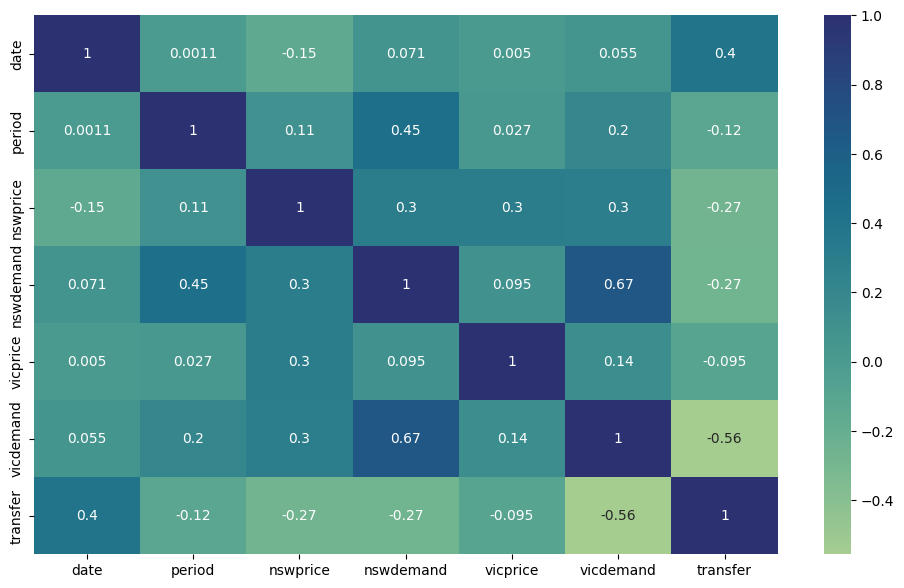

In [20]:
## Visualizing correlation

plt.figure(figsize=(12, 7))

sns.heatmap(corr, annot=True, cmap="crest")

It seems that we don't have features which are too correlating. Correlation shown above varies from `-1 to 1`. If the correlation between two features is close to 1, it means that they nearly contain the same information. If it is close to -1, it means that these features contain different information.Take an example: `vicdemand` correlate with `nswdeman` at 0.67 ratio. 

So if you drop one of those features, it's likely that your model will not be affected much. So different to what you have seen in many articles, having features which does not correlate to the target feature doesn't mean they are not useful. 

In the above correlation matrix, you can see that class feature is not there and this is because it still has categorical values. 

### Task 2: More data exploration

Before preprocessing the data, let's take a look into specific features. 

Let's see how many Ups/Downs are in the class feature.

<AxesSubplot: xlabel='class', ylabel='count'>

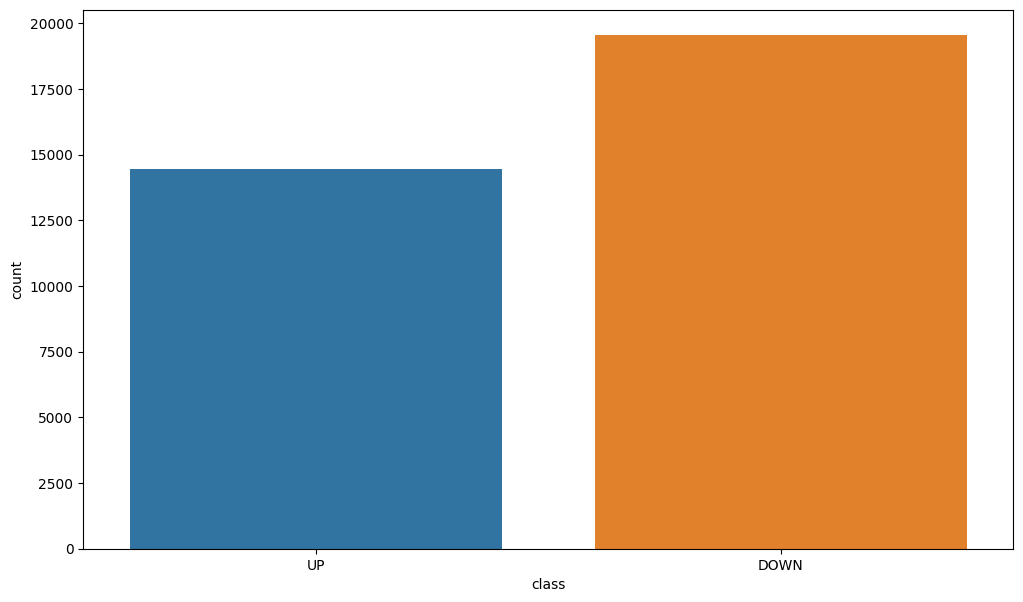

In [21]:
plt.figure(figsize=(12, 7))
sns.countplot(data=train_data, x="class")

`Day` is the days of the week, from 1-7, Monday to Sunday. Let's count the days occurences in respect to the ups/downs of the electricity's price.

<AxesSubplot: xlabel='day', ylabel='count'>

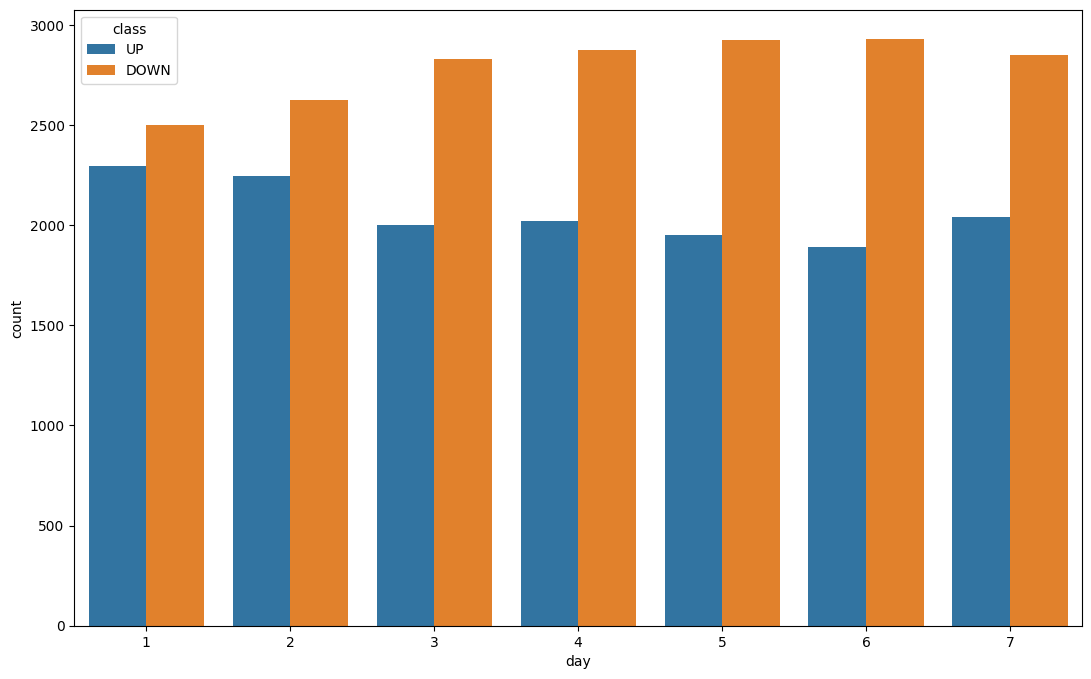

In [22]:
plt.figure(figsize=(13, 8))

sns.countplot(data=train_data, x="day", hue="class")

It seems that most days had downs. From the beginning of the week, there were consistent increase in downs(price of electricity went down) and decrease in ups.
Let's see if there is an appealing relationship between the demand/price of electricity in New South Wales and Victoria.

<AxesSubplot: xlabel='vicdemand', ylabel='nswdemand'>

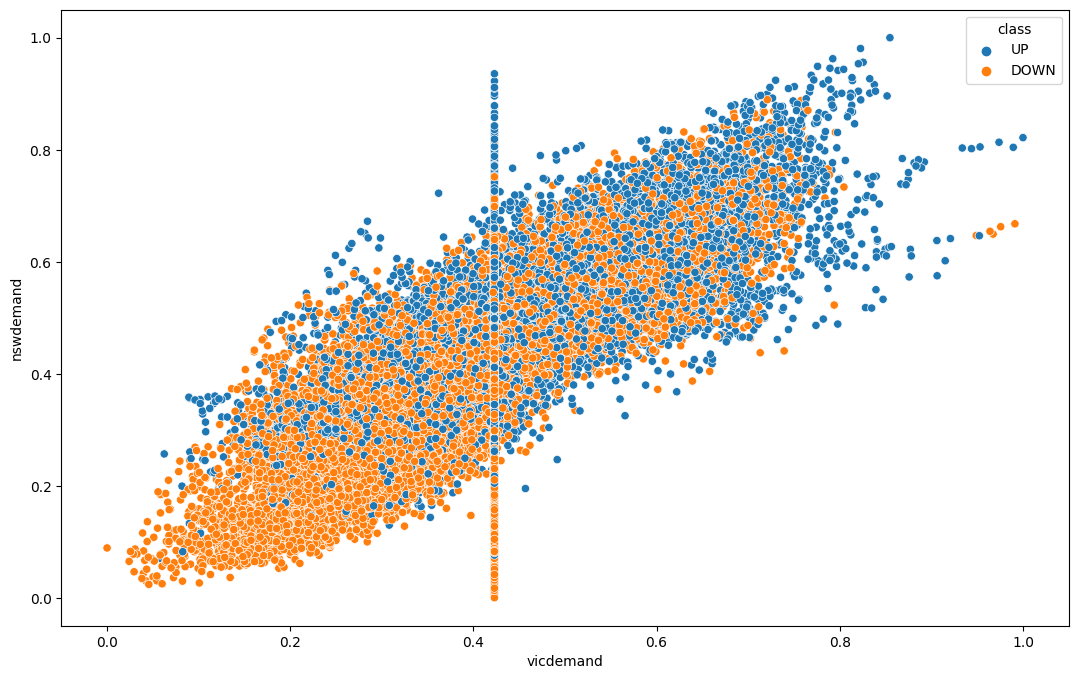

In [23]:
plt.figure(figsize=(13, 8))
sns.scatterplot(data=train_data, x="vicdemand", y="nswdemand", hue="class")

The demand of the electricity in New South Wales and the Victoria is kind of linear. Let's see if we can get any other insights by bringing days in the demand analysis.

<AxesSubplot: xlabel='vicdemand', ylabel='nswdemand'>

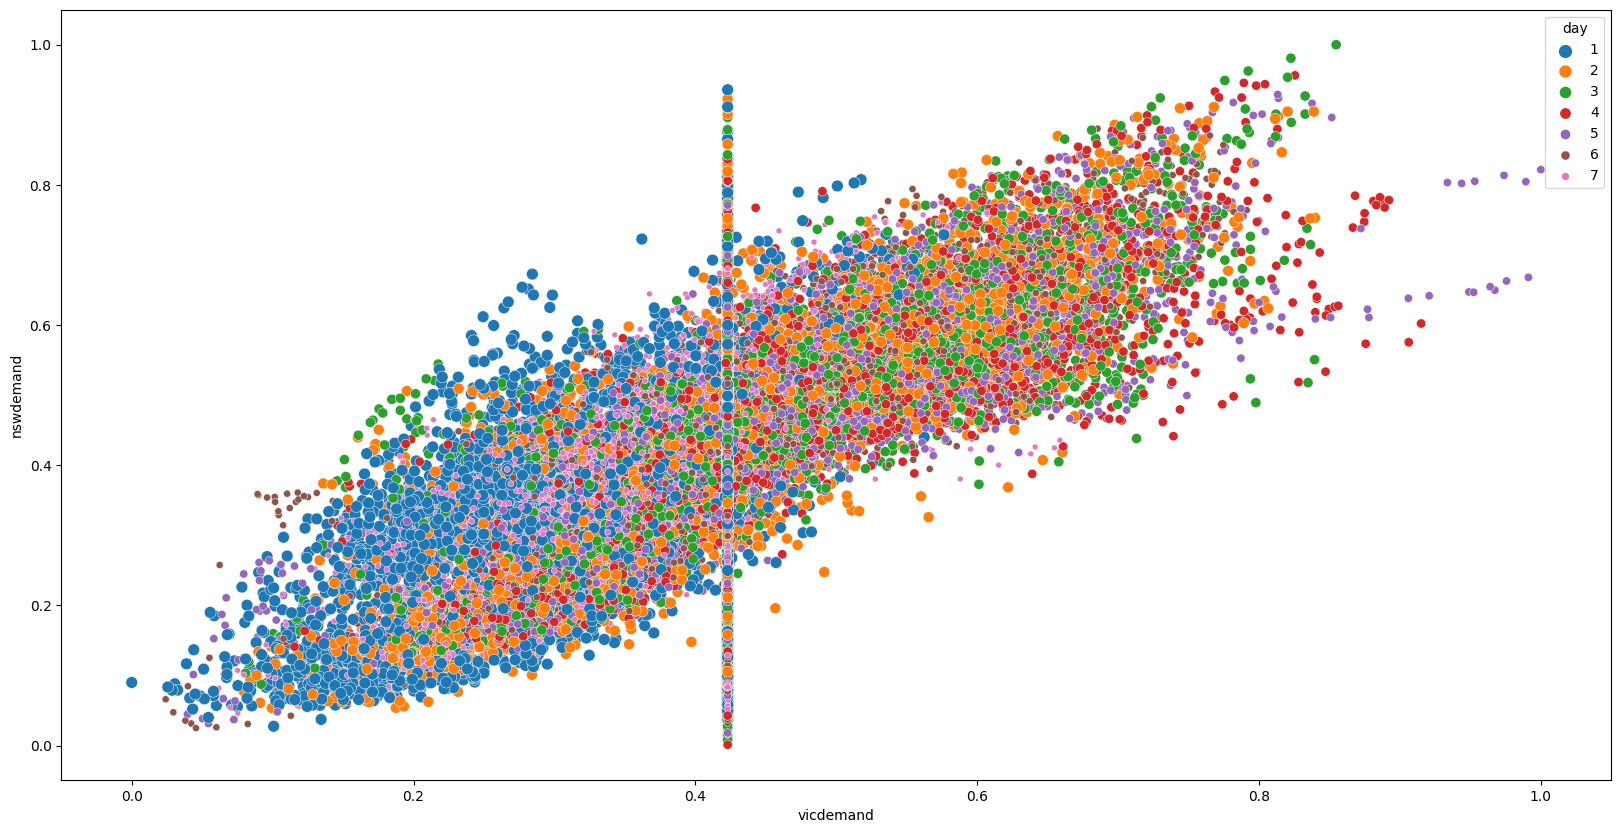

In [24]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=train_data, x="vicdemand", y="nswdemand", hue="day", size="day")

Although it is kind of hard to draw a strong point, there is less demand of electricity in both cities on Monday and Sunday than other days. We can use a line plot to plot the demand in both cities on the course of the days. 

<AxesSubplot: xlabel='day', ylabel='nswdemand'>

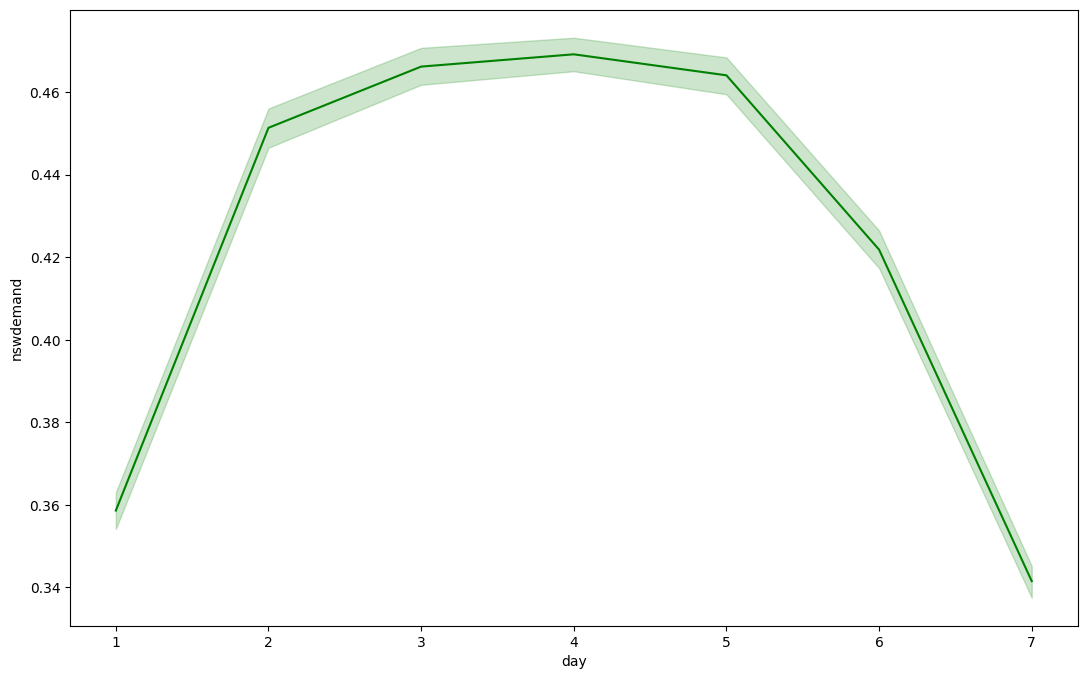

In [25]:
plt.figure(figsize=(13, 8))
sns.lineplot(data=train_data, x="day", y="nswdemand", color="green")

<AxesSubplot: xlabel='day', ylabel='vicdemand'>

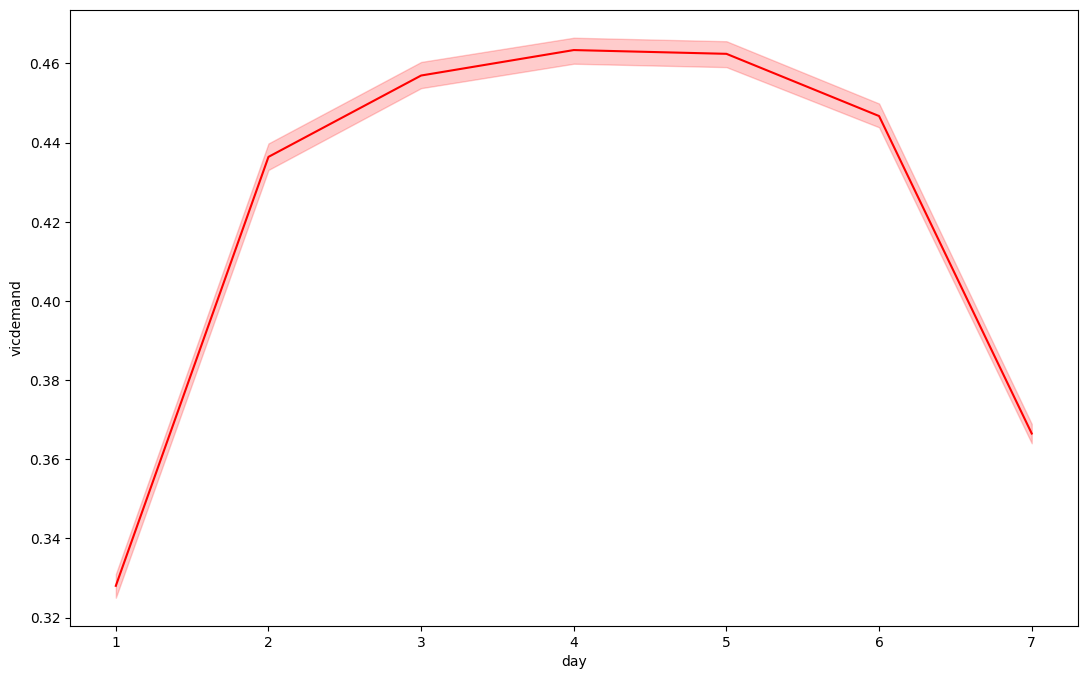

In [26]:
plt.figure(figsize=(13, 8))
sns.lineplot(data=train_data, x="day", y="vicdemand", color="red")

Another interesting thing to look in the dataset is if there are some seasonalities/trends in the demand/price in either Victoria or New South Wales over period of time. In time series analysis, seasonality is when there is repetitive scenarios or consistent behaviours over the course of time. 

If you look at the demand of the electricity in both cities on the course of date (`7 May 1996 to 5 December 1998`), you can see that there are some types of seasonalities. Not 100% but it seems there is and if this dataset would have been collected for more than two years, it would probably be easy to know surely if there are seasonalities. 

<AxesSubplot: xlabel='date', ylabel='nswdemand'>

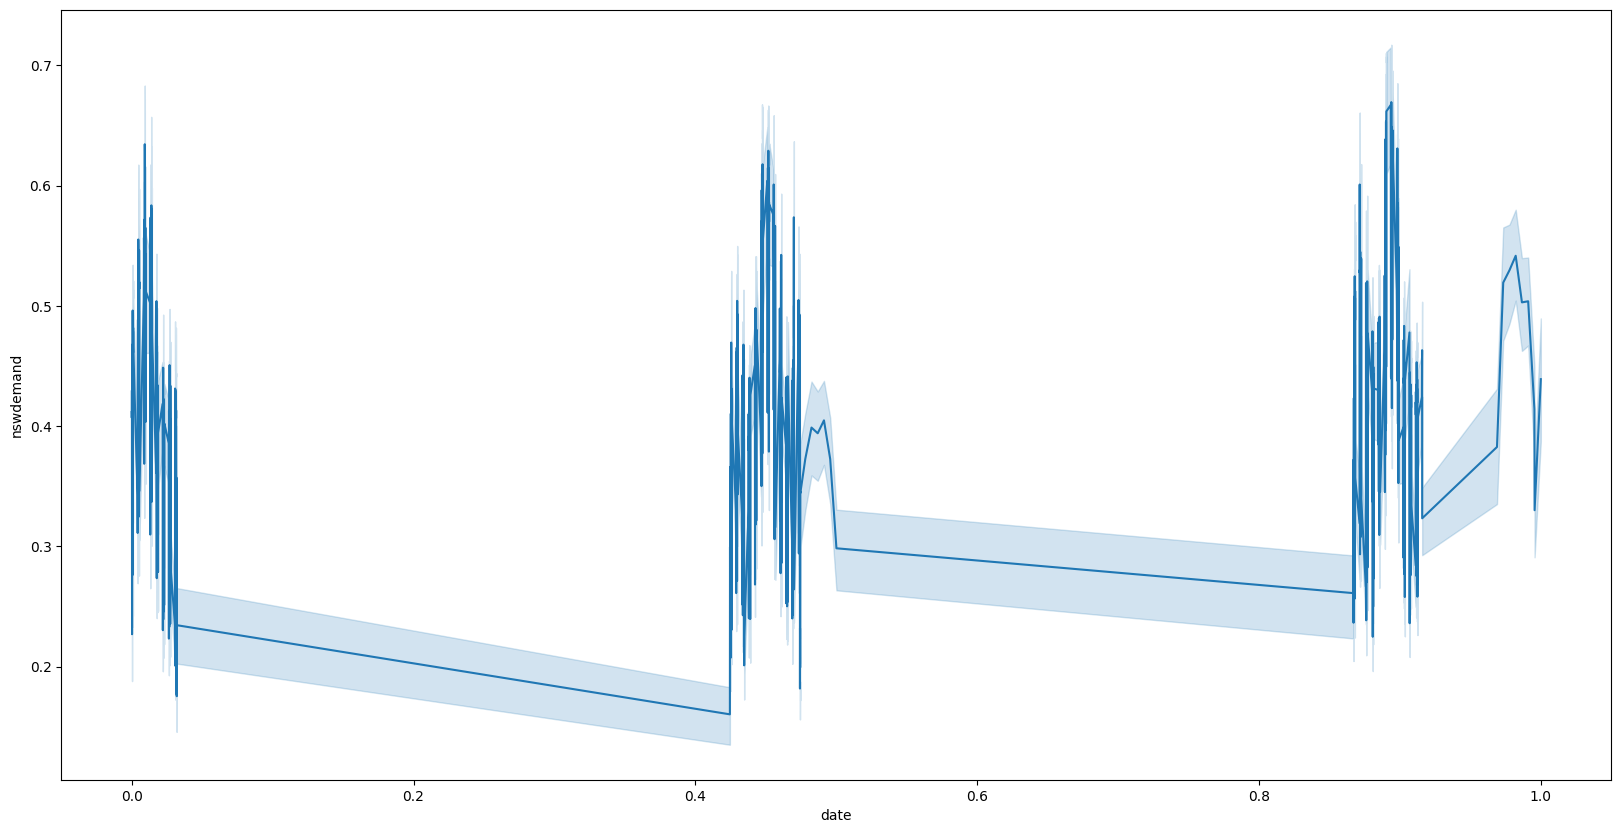

In [27]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=train_data, x="date", y="nswdemand")

<AxesSubplot: xlabel='date', ylabel='vicdemand'>

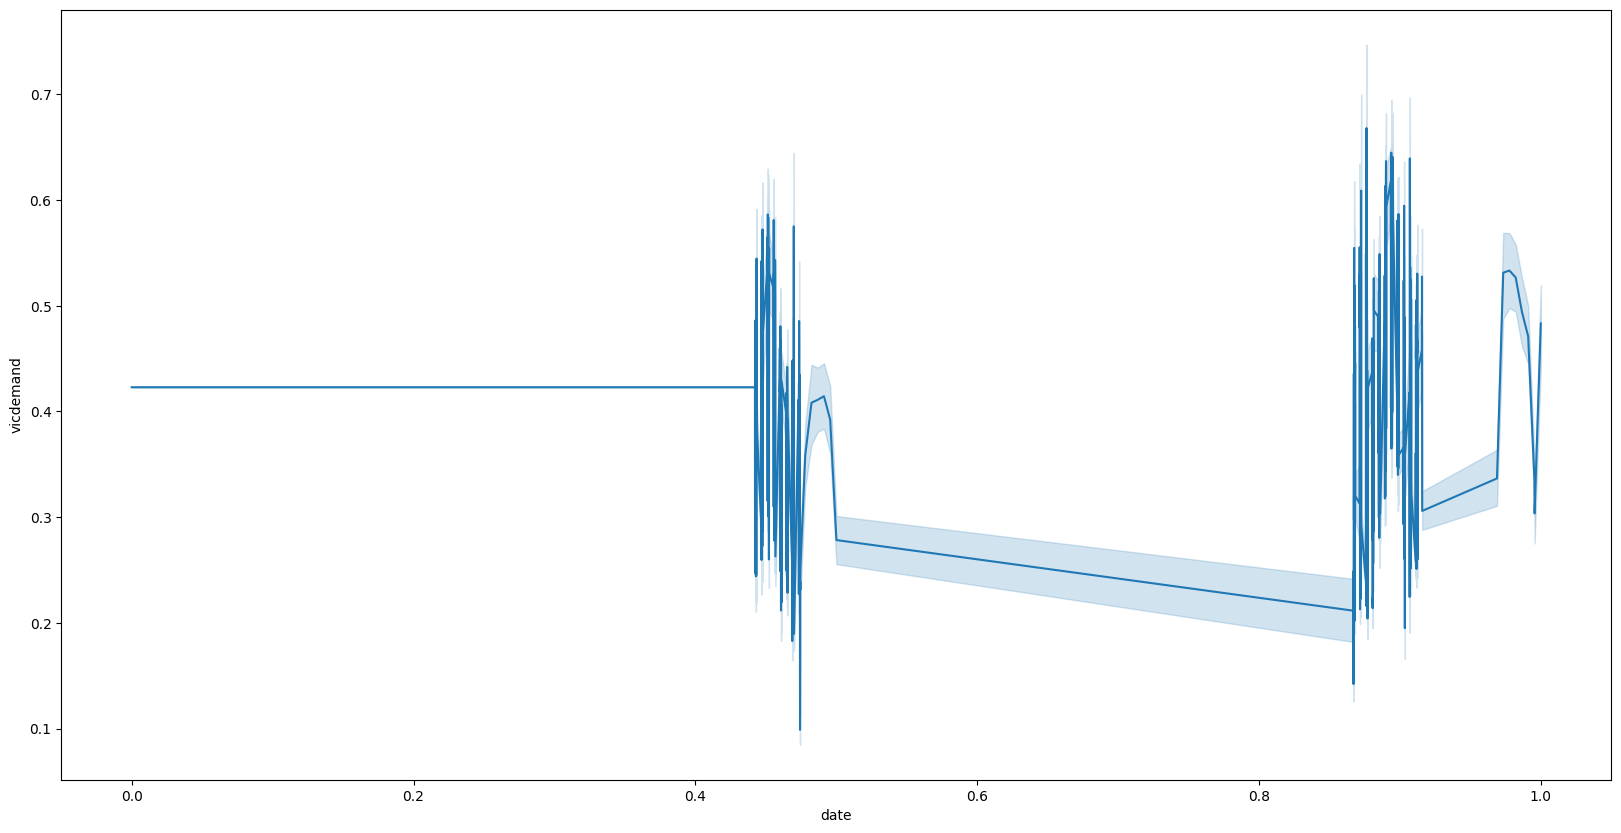

In [28]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=train_data, x="date", y="vicdemand")

One last thing about data analysis, let's plot all histograms of the numerical features. 

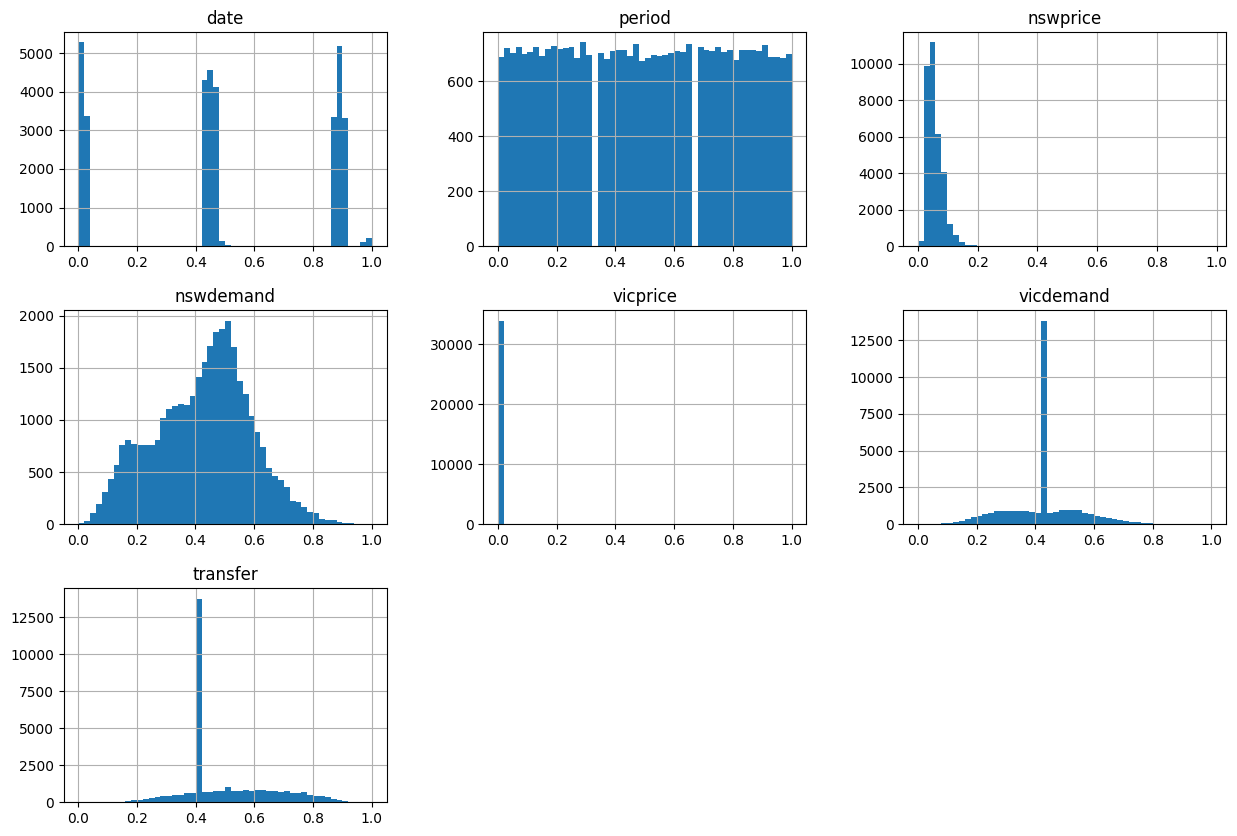

In [29]:
train_data.hist(bins=50, figsize=(15, 10))
plt.show()

### Task 3: Data preprocessing 

It is here that we prepare the data to be in the proper format for the machine learning model. 

Let's encode the categorical feature `class`. But before that, let's take training input data and labels.

In [30]:
X_train = train_data.drop("class", axis=1)
y_train = train_data["class"]

In [31]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y_train_prepared = label_enc.fit_transform(y_train)

In [32]:
X_train.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
27325,0.469846,4,0.276596,0.164705,0.519637,0.011417,0.657949,0.265789
28731,0.474227,5,0.574468,0.024919,0.191907,0.001656,0.090886,0.819737
8450,0.023141,3,0.042553,0.065270,0.250074,0.003467,0.422915,0.414912
36659,0.889385,2,0.744681,0.148193,0.670039,0.009981,0.533402,0.563596
781,0.000708,4,0.276596,0.124204,0.475454,0.003467,0.422915,0.414912


Because in python, it does not make sense to perform a multiplication between a sequence (list, tuple, etc.) and a float, so for subsequent operations, we need to convert X_train into an array.

In [33]:
X_train = np.array(X_train)

In [34]:
X_train

array([[0.469846, '4', 0.276596, ..., 0.011417, 0.657949, 0.265789],
       [0.474227, '5', 0.574468, ..., 0.001656, 0.090886, 0.819737],
       [0.023141, '3', 0.042553, ..., 0.003467, 0.422915, 0.414912],
       ...,
       [0.460422, '7', 0.319149, ..., 0.001813, 0.269032, 0.564035],
       [0.889828, '5', 0.659574, ..., 0.002021, 0.625583, 0.248684],
       [0.469625, '6', 0.553191, ..., 0.003712, 0.545572, 0.229825]],
      dtype=object)

In [35]:
y_train_prepared

array([0, 0, 0, ..., 0, 0, 1])

Now we are ready to train the machine learning model. 

But again if you look at the dat, the `day` feature is not normalized as other features. We can normalize it or leave it but for now let's go ahead and train the random forests classifier. 

### Task 4: Training ensemble classifiers

#### 4.1: Voting classifier

Let's assume that you have trained 3 different classifiers on the training data but none of these classifiers had an oustanding results. 

The idea of Voting ensemble technique is fairly simple. We can aggregate the results of all those 3 classifiers and the result will be good than any single classifier. 

Let's train 3 classifiers on the training data and then we will go ahead and aggregate their results. 

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score

log_classifier = LogisticRegression()
sv_classifier = SVC()
sgd_classifier = SGDClassifier()


def classifiers(clf1, clf2, clf3, X_train, y_train):

    """
    A function that takes 5 inputs: 3 classifiers, training data & labels
    And return the list of accuracies on all classifiers

    """

    # A list of all classifiers
    clfs = [clf1, clf2, clf3]

    # An empty list to comprehend
    all_clfs_acc = []

    # Train each classifier, evaluate it on the training set
    # And append the accuracy to 'all_clfs_acc'

    for clf in clfs:

        clf.fit(X_train, y_train)
        preds = clf.predict(X_train)
        acc = accuracy_score(y_train, preds)
        acc = acc.tolist()
        all_clfs_acc.append(acc)

    return all_clfs_acc

In [37]:
classifiers(log_classifier, sv_classifier, sgd_classifier, X_train, y_train_prepared)

[0.7510593220338984, 0.7368761770244822, 0.753707627118644]

As you can see, the function returned 3 accuracies on the training set. The first accuracy correspond to Logistic Regression, the second is Support Vector Classifier, and the third is SGD(Stockastic Gradient Descent).

Now, let us use Voting Classifier to aggregate the results of all of those 3 classifiers. 

In [38]:
from sklearn.ensemble import VotingClassifier

vot_classifier = VotingClassifier(
    estimators=[
        ("log_reg", log_classifier),
        ("svc", sv_classifier),
        ("sgd", sgd_classifier),
    ],
    voting="hard",
)

vot_classifier.fit(X_train, y_train_prepared)

VotingClassifier(estimators=[('log_reg', LogisticRegression()), ('svc', SVC()),
                             ('sgd', SGDClassifier())])

Since we will need to calculate accuracy often, let's make a function to be calling always. 

In [39]:
from sklearn.metrics import accuracy_score


def accuracy(model, data, labels):

    predictions = model.predict(data)
    acc = accuracy_score(labels, predictions)

    return acc

Let's use the above function to find the accuracy of the voting classifier

In [40]:
accuracy(vot_classifier, X_train, y_train_prepared)

0.7458804143126178

As we can see, it slightly outperformed all individual classifiers. It's small increments in the accuracy but most of the time, it will be always better than any individual classifier. 

#### 4.2: Bagging classifier

Instead of training different algorithms on the same data and average their results as Voting does, Bagging ensemble method train a single or multiple classifier/regressors on different subsets of the training data and aggregate the results on all subsets. 

When this is used with complex models (that overfit data easily) like decision trees, the overfitting can be reduced. 

Let's use bagging to train 500 decision trees on different subsets of data and then average the predictions on those subsets. 

By setting `max_samples=0.5`, `max_features=0.5`, `bootstrap=False`, we are using random 50% subsets of training data and random 50% subsets of features. If bootstrap is `True`, ratio of those training samples are sampled from the training data with replacement and if it is False, there is no replecement. When in fact bootstrap is `False`, this is called Pasting. There are also other techniques called Random Subspaces and Random Patches and they are all based off how the samples are drawn from the data. you can learn more about these techniques and more about other hyperparameters on the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#bagging). 

One of the great way to improve a particular machine learning model is to learn about its hyperparameters and what each stands for. So, you can learn more about Bagging [here](https://scikit-learn.org/stable/modules/ensemble.html#id2). 

In [41]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_classifier = BaggingClassifier(
    DecisionTreeClassifier(class_weight="balanced"),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
)

bag_classifier.fit(X_train, y_train_prepared)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                  bootstrap=False, max_features=0.5, max_samples=0.5)

In [42]:
accuracy(bag_classifier, X_train, y_train_prepared)

0.9804025423728814

Wow, this is much better. Bagging ensembles work well and they outperform Voting ensembles a lot. Other remarkable thing about them is that they are able to overcome the overfitting especially when used with decision trees (decision trees tend to overfit easily). Let's now see other type of ensemble models: Gradient Boosting Classifier.

#### 4.3: Gradient boosting classifier

Gradient boosting works like bagging methods. The only difference is that instead of training models on subsets of training data, models(decision trees) are trained in a sequence where each tree model takes the error of the previous tree to correct it and the sequence goes on...

Simply, the initial model is trained on the full data, but then the next models minimizes the previous errors. 

Just like other models, gradient boosting classifier has hyperparameters but the most important ones are number of estimators or trees (`n_estimators`) and learning rate (`learning_rate`). 

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

grad_boost_clf = GradientBoostingClassifier(
    n_estimators=500, learning_rate=0.8, random_state=42, max_depth=2
)

grad_boost_clf.fit(X_train, y_train_prepared)

GradientBoostingClassifier(learning_rate=0.8, max_depth=2, n_estimators=500,
                           random_state=42)

Let's evaluate it on the training set. 

In [44]:
accuracy(grad_boost_clf, X_train, y_train_prepared)

0.9269362052730696

One disadvantage of the Gradient Boosting ensemble method is that it is easy to overfit, and that has to do with how they works. By minimizing the errors consecutively (tree after tree), they can be so perfect but the of course won't be perfect when fed to the test data. 


One way to avoid overfitting is to carefully choose the learning rate that scale well with the number of estimators. Although the high number of estimators can't necessarily cause overfitting (gradient boosting is a robust model), the learning rate has to be low. In other words, there is a trade off between these two hyperparameters. The higher the learning rate, the lower estimators and vice versa. If you can get a good results with low learning rate, there is a chance that it will generalize well on test too. 

You can spend sometime to change these two parameters and try to see their effects.

For classification problems beyond two classes, Scikit-Learn recommend using [Histogram Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) which is a faster version of the Gradient Boosting Classifier. It is inspired by [Microsoft Light Gradient Boosting Machine (LightGBM)](https://github.com/Microsoft/LightGBM). LightGBM is fater, low memory usage, better performance, support distributed training and GPU, and can handle large datasets. 

#### 4.4: AdaBoost classifier

AdaBoost is another ensemble model in class of boosting methods. It's very much like gradient boost but instead of minimizing the error of the consecutive models, it updates the weights. 

So, the first model (decision tree) is trained on the full training data, the next model weights are updated based off the previous weights and so forth. 

The main parameters to tune to make AdaBoost work well are number of estimators and the maximum depth of each estimator. 

In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaboost_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, class_weight="balanced"),
    # base estimator is decision trees by default
    n_estimators=300,
    learning_rate=0.5,
)

adaboost_clf.fit(X_train, y_train_prepared)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=3),
                   learning_rate=0.5, n_estimators=300)

Let's evaluate it on the training set. 

In [46]:
accuracy(adaboost_clf, X_train, y_train_prepared)

0.93717631826742

Again, you can tune the number of estimators and the depth of the base estimator. The base estimator is Decision Trees by default. 

#### 4.5: Stacking classifier

Also referred to as Stacked Generalization, it is an ensemble method employed to reduce the biases and the errors rate made by multiple predictors(individual models/estimators). 

Instead of averaging the predictions made by individual models or predictors, in stacking, multiple models are trained on the full training data and then the final model that is trained on different subsets of the training data takes the predictions of the former models and find the final predictions. 

From its [original paper](http://machine-learning.martinsewell.com/ensembles/stacking/Wolpert1992.pdf), it is noted that it can be seen as the sophisticated version of the cross validation (per the reason why the final estimator is trained on the subsets or folds of the training data). 

In [47]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


base_estimators = [
    ("rand", RandomForestClassifier(random_state=42)),
    ("svc", SVC(random_state=42)),
]

final_estimator = LogisticRegression()

stack_clf = StackingClassifier(
    estimators=base_estimators, final_estimator=final_estimator
)

stack_clf.fit(X_train, y_train_prepared)

StackingClassifier(estimators=[('rand',
                                RandomForestClassifier(random_state=42)),
                               ('svc', SVC(random_state=42))],
                   final_estimator=LogisticRegression())

Let's evaluate it on the training set. 

In [48]:
accuracy(stack_clf, X_train, y_train_prepared)

0.9996468926553672

Ohh the accuracy looks appealing! But is it really? It might be that we overfitted the training data. 

### Task 5: Evaluating the ensemble model on the test set

Let's say that all we have been doing was trying to find an ensemble model that can fit well the data and so we want to test it on the test set before shipping it into production. 

To narrow the choice down, we will use A Gradient Boosting method. 

As always, we will prepare the test set in the same way that we prepared the training set. Let's go!

In [57]:
X_test = test_data.drop("class", axis=1)
y_test = test_data["class"]

y_test_prepared = label_enc.transform(y_test)

In [59]:
accuracy(grad_boost_clf, X_test, y_test_prepared)

0.8968926553672316

That's not really bad considering that the model never saw the test data anywhere in previous steps. The Gradient boosting method had nearly 92% on the training data.

Let's also evaluate the stacking classifier. It was overly optimistic on the training data, nearly 100%! 

In [62]:
accuracy(stack_clf, X_test, y_test_prepared)

0.9021892655367232

How about trying a bag classifier also? It had nearly 98% on the training data. 

In [63]:
accuracy(bag_classifier, X_test, y_test_prepared)

0.8573446327683616

As we can see, all of the ensembles are not generalizing well on the test set. It's not that bad again, but there is a room of improvement. One sure way to improve the results of machine learning model is to improve the data. 

You may also have to tune the hyperparamaters of the particular ensemble method and this works sometime too.

## Final note

This notebook was all about ensemble learning methods. There is truly a `wisdom in the crowd`(CC: Aurelion Geron). By averaging the results of different models, we are able to improve the overall prediction. 

There is a notion that ensemble models are slow and expensive to run in production. It's true, but with the advent of computation power and how incredible these types of ML models work well, that's no longer issue for someone. They are complex algorithms but they can also reduce complexity. How? 

Think about it: Instead of building a single complex model (typically a neural network), you can build small models that will train and compute predictions faster and then average their results using a given ensemble method. By that way, you are leveraging ensemble methods to reduce complexity. 

To learn more about the ensemble models, you can refer to this chapter `Chapter 7 Ensemble Learning and Random Forests` of the book [Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). 

## Acknowledgments

Thanks to Nyandwi for creating the open-source course [Machine Learning complete](https://github.com/Nyandwi/machine_learning_complete). It inspires the majority of the content in this chapter.